<a href="https://colab.research.google.com/github/amk735/DS340W-project-flower-image-classification/blob/main/VGG19andTransferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# New Section

In [ ]:
#!ls

In [ ]:
#%cd gdrive/MyDrive/DS340

In [ ]:
#! git clone https://github.com/amk735/DS340W-project-flower-image-classification

In [ ]:
#!git clone https://github.com/amk735/DS340W-project-flower-image-classification/tree/main/Few-Shot-Limited-Data-main/MAML/flowerImages
#clone dataset

In [ ]:
import os
import numpy as np

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras import optimizers, callbacks
import tensorflow.keras.backend as K

%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense

In [ ]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
config = tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU') 
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
image_width = 224
image_height = 224
num_classes = 5
histories = []

In [ ]:
images_dir = "/content/drive/MyDrive/DS340/images/"
train_data_dir = images_dir + "train/" #/content/drive/MyDrive/DS340/images/"#images_dir + "train/"
val_data_dir = images_dir + "val/"
test_data_dir = images_dir + "test/"

In [ ]:
images_dir = "/content/drive/MyDrive/DS340/images/"
flowers_complete = "/content/drive/MyDrive/DS340/flowers/"
train_data_dir = images_dir + "train/" #"/content/drive/MyDrive/DS340/images/"#images_dir + "train/"
val_data_dir = flowers_complete
test_data_dir = flowers_complete #+ "test/"

In [ ]:
checkpoint_dir = "checkpoints/"
checkpoint_name = checkpoint_dir + "flora-transferLearning-{val_loss:.4f}-{val_accuracy:.4f}.hdf5"
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

In [ ]:
#%matplotlib inline
##import

In [ ]:
def create_callbacks():
    return [
        callbacks.EarlyStopping(monitor="val_accuracy", patience=10, verbose=1),

        callbacks.ModelCheckpoint(checkpoint_name, monitor="val_accuracy", 
                                  verbose=1, save_best_only=True),
    ]

my_callbacks = create_callbacks()

In [ ]:
my_callbacks = create_callbacks()


In [ ]:
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input

base_model = VGG19(input_shape=(image_height, image_width, 3), 
                   include_top=False, weights="imagenet", pooling=None)



In [ ]:
train_datagen = ImageDataGenerator(
                    rotation_range=40,
                    width_shift_range=0.2,
                    height_shift_range=0.2,
                    shear_range=0.2,
                    zoom_range=0.2,
                    channel_shift_range=0.2,
                    horizontal_flip=True,
                    fill_mode="nearest",
                    preprocessing_function=preprocess_input)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)


In [ ]:
#print(train_data_dir)

In [ ]:
#os.getcwd()

In [ ]:
#os.chdir(/content/drive/MyDrive/Github)

In [ ]:
batch_size = 64

#import os
#print(os.listdir("/content/drive/MyDrive/DS340"))

train_generator = train_datagen.flow_from_directory(
                    train_data_dir + '',
                    target_size=(image_width, image_height),
                    batch_size=batch_size,
                    class_mode="categorical",
                    shuffle=True)

val_generator = val_datagen.flow_from_directory(
                    val_data_dir,
                    target_size=(image_width, image_height),
                    batch_size=batch_size,
                    class_mode="categorical",
                    shuffle=False)

test_generator = test_datagen.flow_from_directory(
                    test_data_dir,
                    target_size=(image_width, image_height),
                    batch_size=batch_size,
                    class_mode="categorical",
                    shuffle=False)
print(train_data_dir)
print(val_data_dir)
print(test_data_dir)

Found 25 images belonging to 5 classes.
Found 4317 images belonging to 5 classes.
Found 4317 images belonging to 5 classes.
/content/drive/MyDrive/DS340/images/train/
/content/drive/MyDrive/DS340/flowers/
/content/drive/MyDrive/DS340/flowers/


In [ ]:
#len(val_generator)
val_generator.class_indices

{'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}

In [ ]:
from tensorflow.keras import regularizers

top_model = Sequential()
top_model.add(base_model)
top_model.add(GlobalAveragePooling2D())
top_model.add(Dropout(0.7))
top_model.add(Dense(num_classes, kernel_regularizer=regularizers.l2(0.01)))
top_model.add(Activation("softmax"))

print(top_model)

In [ ]:
from tensorflow.keras import regularizers

model = Sequential()
model.add(base_model)
model.add(Conv2D(64, (3, 3), input_shape=(image_height, image_width, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#b
model.add(Conv2D(32, (1, 1)))
model.add(Activation('relu'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation("softmax"))

print(model)

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

top_model.compile(loss="categorical_crossentropy",
                  optimizer=optimizers.Adam(learning_rate=1e-4), #changed lr to learning_rate
                  metrics=["accuracy"])   

print(top_model) 

In [ ]:
histories.append(top_model.fit(train_generator, 
                              steps_per_epoch=len(train_generator),
                              epochs=125,
                              callbacks=my_callbacks,
                              validation_data=val_generator,
                              validation_steps=len(val_generator),
                              workers=8))


Epoch 1/125
1/1 [==============================] - ETA: 0s - loss: 12.4143 - accuracy: 0.1200
Epoch 1: val_accuracy improved from 0.27241 to 0.27264, saving model to checkpoints/flora-transferLearning-5.3404-0.2726.hdf5
1/1 [==============================] - 29s 29s/step - loss: 12.4143 - accuracy: 0.1200 - val_loss: 5.3404 - val_accuracy: 0.2726
Epoch 2/125
1/1 [==============================] - ETA: 0s - loss: 8.4018 - accuracy: 0.5200
Epoch 2: val_accuracy improved from 0.27264 to 0.27334, saving model to checkpoints/flora-transferLearning-5.3344-0.2733.hdf5
1/1 [==============================] - 26s 26s/step - loss: 8.4018 - accuracy: 0.5200 - val_loss: 5.3344 - val_accuracy: 0.2733
Epoch 3/125
1/1 [==============================] - ETA: 0s - loss: 9.1907 - accuracy: 0.2400
Epoch 3: val_accuracy improved from 0.27334 to 0.27357, saving model to checkpoints/flora-transferLearning-5.3286-0.2736.hdf5
1/1 [==============================] - 42s 42s/step - loss: 9.1907 - accuracy: 0.2400

In [ ]:
print(top_model)

Evaluate on the best model

In [ ]:
from tensorflow.keras.models import load_model
model_saved_name = ""
#flora-transferLearning-1.7142-0.3280.hdf5
best_model = load_model(checkpoint_dir + "flora-transferLearning-4.8647-0.3243.hdf5")
                        #"flora-transferLearning-1.7202-0.3231.hdf5")
                        #"flora-transferLearning-1.6939-0.3410.hdf5")
                        
                        #"flora-transferLearning-1.7142-0.3280.hdf5")#"flora-transferLearning-1.6966-0.3394.hdf5")

In [ ]:
best_model.evaluate_generator(test_generator, steps=len(test_generator)) #60 epochs


[4.864669322967529, 0.32429927587509155]

In [ ]:
test_generator.reset()
probabilities = best_model.predict_generator(test_generator, steps=len(test_generator))
predicted_labels = np.argmax(probabilities, axis=-1)

In [ ]:
target_labels = test_generator.classes


In [ ]:
from sklearn import metrics
conf = metrics.confusion_matrix(target_labels, predicted_labels)

In [ ]:
import seaborn as sns

def plot_confusion_matrix(conf, labels, figsize=(8, 8)):
    fig = plt.figure(figsize=figsize)
    heatmap = sns.heatmap(conf, annot=True, fmt="d")
    heatmap.xaxis.set_ticklabels(labels, rotation=45, ha="right", fontsize=12)
    heatmap.yaxis.set_ticklabels(labels, rotation=0, ha="right", fontsize=12)
    plt.xlabel("Predicted label", fontsize=12)
    plt.ylabel("True label", fontsize=12)
    plt.show()

In [ ]:
labels = [""] * num_classes
for k, v in test_generator.class_indices.items():
    labels[v] = k

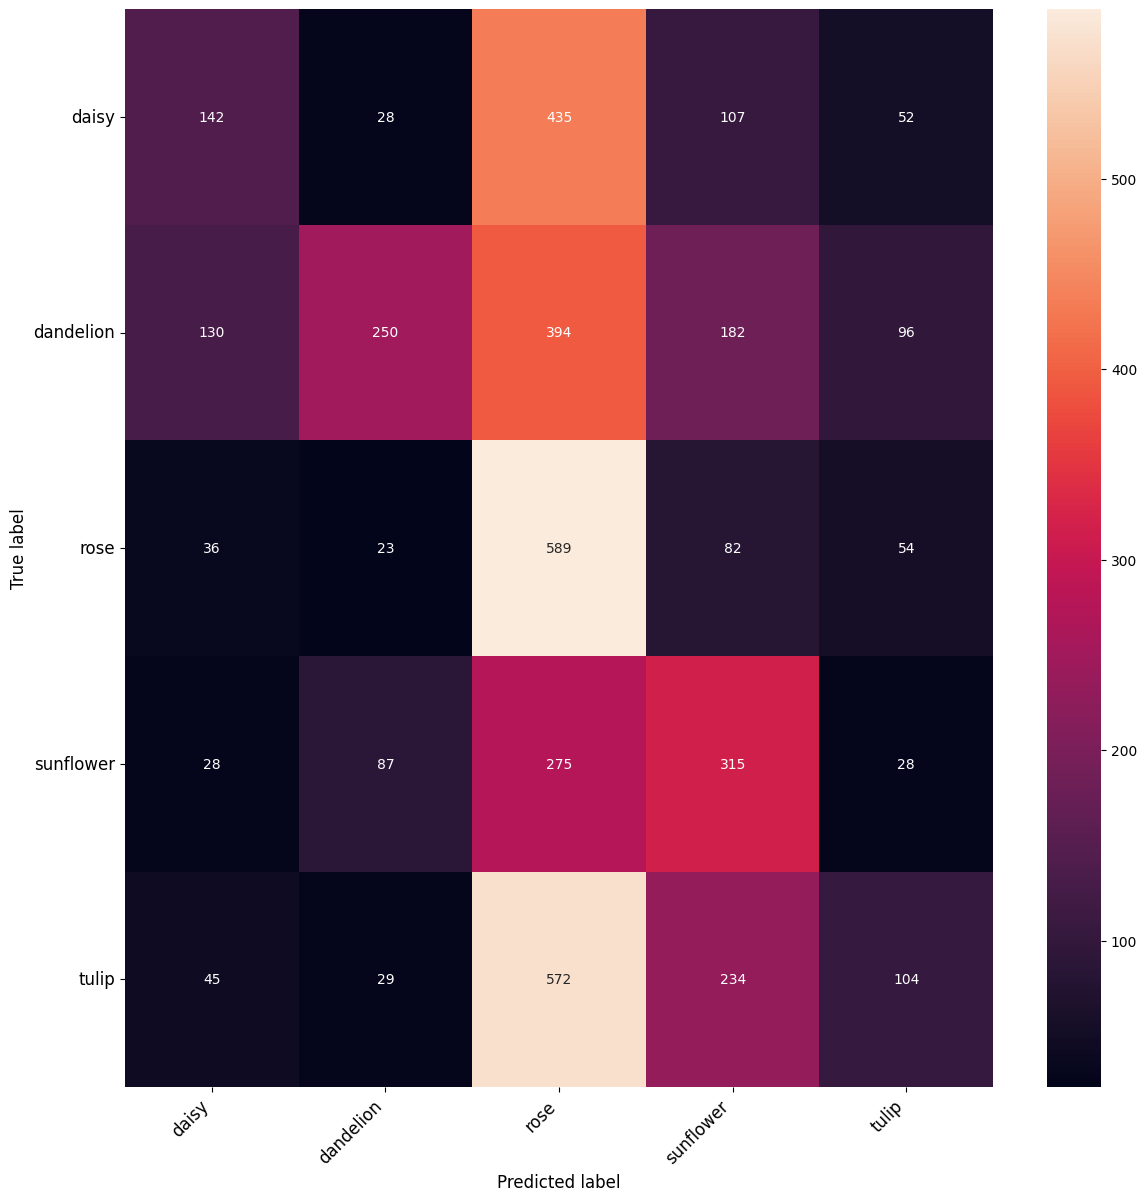

In [ ]:
plot_confusion_matrix(conf, labels, figsize=(14, 14))


In [ ]:
print(metrics.classification_report(target_labels, predicted_labels, target_names=labels))


              precision    recall  f1-score   support

       daisy       0.37      0.19      0.25       764
   dandelion       0.60      0.24      0.34      1052
        rose       0.26      0.75      0.39       784
   sunflower       0.34      0.43      0.38       733
       tulip       0.31      0.11      0.16       984

    accuracy                           0.32      4317
   macro avg       0.38      0.34      0.30      4317
weighted avg       0.39      0.32      0.30      4317



In [ ]:
# Find for which images the predicted class is wrong
wrong_images = np.where(predicted_labels != target_labels)[0]

# For every prediction, find the largest probability value;
# this is the probability of the winning class for this image
probs_max = np.max(probabilities, axis=-1)

# Sort the probabilities from the wrong images from low to high
idx = np.argsort(probs_max[wrong_images])

# Reverse the order (high to low), and keep the 5 highest ones
idx = idx[::-1][:5]#[1::][:5]#[::-1][:5]

# Get the indices of the images with the worst predictions
worst_predictions = wrong_images[idx]

index2class = {v:k for k,v in test_generator.class_indices.items()}

for i in worst_predictions:
    print("%s was predicted as '%s' %.4f\n" % (
        test_generator.filenames[i],
        index2class[predicted_labels[i]],
        probs_max[i]
    ))

tulip/4582198748_20fa7caaa1.jpg was predicted as 'rose' 1.0000

tulip/142235914_5419ff8a4a.jpg was predicted as 'sunflower' 1.0000

tulip/7042692841_f323799c0d.jpg was predicted as 'sunflower' 1.0000

tulip/7205145492_baec4dbb94.jpg was predicted as 'sunflower' 1.0000

tulip/4574785121_5d8ec4626e.jpg was predicted as 'rose' 1.0000



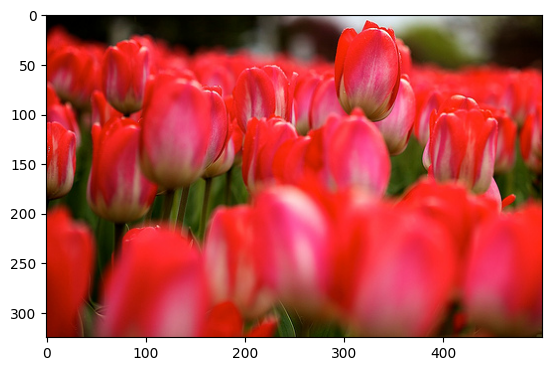

In [ ]:
from keras.preprocessing import image
import keras.utils as image

img = image.load_img(test_data_dir + test_generator.filenames[worst_predictions[0]])
plt.imshow(img)

Export to Core ML
Restart kernel with mlvenv with "source mlvenv/bin/activate" for coremltools part



In [ ]:
!pip3 install coremltools


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 32.6 MB/s eta 0:00:00


In [ ]:
import coremltools as ct
import os
from tensorflow.keras.models import load_model

In [ ]:
import tensorflow
#import keras
#import tensorflow.keras
from tensorflow.keras.models import load_model


In [ ]:
label_dir = "ava/"
labels = []
checkpoint_dir = "checkpoints/"
best_model = tensorflow.keras.load_model(checkpoint_dir + "multisnacks-1.6708-0.4054.hdf5")


AttributeError: ignored

In [ ]:
for i in os.listdir(label_dir):
    if i != '.DS_Store' and i != '._.DS_Store':
        labels.append(i)

FileNotFoundError: ignored

In [ ]:
coreml_model = ct.convert(
    best_model,
    input_names=["image"],
    image_input_names="image",
    output_names="labelProbability",
    predicted_feature_name="label",
    red_bias=-1,
    green_bias=-1,
    blue_bias=-1,
    image_scale=2/255.0,
    class_labels=labels)

TypeError: ignored

In [ ]:
coreml_model.author = "Joshua Ball"
coreml_model.short_description = "Image classifier"

coreml_model.input_description["image"] = "Input image"
coreml_model.output_description["labelProbability"]= "Prediction probabilities"
coreml_model.output_description["label"]= "Class label of top prediction"

NameError: ignored

In [ ]:
coreml_model.save("MultiSnacks.mlmodel")


NameError: ignored

In [ ]:
m = ct.models.MLModel("MultiSnacks.mlmodel")


FileNotFoundError: ignored

In [ ]:
import numpy as np
import PIL.Image

In [ ]:
Height = 224  # use the correct input image height
Width = 224  # use the correct input image width

In [ ]:
def load_image(path, resize_to=None):
    # resize_to: (Width, Height)
    img = PIL.Image.open(path)
    if resize_to is not None:
        img = img.resize(resize_to, PIL.Image.ANTIALIAS)
    img_np = np.array(img).astype(np.float32)
    return img_np, img

In [ ]:
_, img = load_image('ava/Ripe/focused_184465770-stock-photo-whole-ripe-avocado.jpg', resize_to=(Width, Height))
out_dict = m.predict({'image': img})

FileNotFoundError: ignored

In [ ]:
from skimage import io
import matplotlib.pyplot as plt
image = io.imread('a.jpg')

_ = plt.hist(image.ravel(), bins = 256, color = 'orange', )
_ = plt.hist(image[:, :, 0].ravel(), bins = 256, color = 'red', alpha = 0.5)
_ = plt.hist(image[:, :, 1].ravel(), bins = 256, color = 'Green', alpha = 0.5)
_ = plt.hist(image[:, :, 2].ravel(), bins = 256, color = 'Blue', alpha = 0.5)
_ = plt.xlabel('Intensity Value')
_ = plt.ylabel('Count')
_ = plt.legend(['Total', 'Red_Channel', 'Green_Channel', 'Blue_Channel'])
plt.show()

FileNotFoundError: ignored

FileNotFoundError: ignored

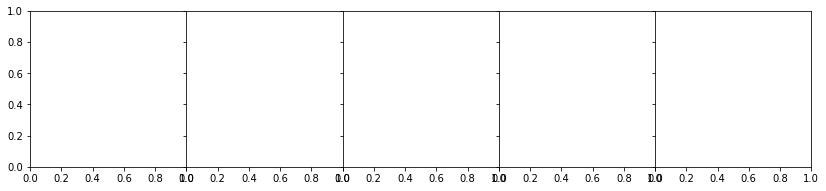

In [ ]:
from mpl_toolkits.axes_grid1 import ImageGrid
fig = plt.figure(figsize=(14., 14.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(1, 5),  # creates 2x2 grid of axes
                 axes_pad=0.0,  # pad between axes in inch.
                 )

image_data = [io.imread('a.jpg'), io.imread('b.jpg'),io.imread('c.jpg'),io.imread('d.jpg'),io.imread('e.jpg')]
for ax, im in zip(grid, image_data):
    # Iterating over the grid returns the Axes.
    ax.imshow(im,interpolation='nearest') 
    ax.set_axis_off()

    plt.axis('off')
plt.show()

FileNotFoundError: ignored

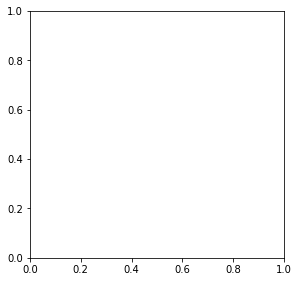

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(2, 2, 1)
imgplot = plt.imshow(io.imread('a.jpg'))
ax.set_title('Rose')
#plt.colorbar(ticks=[0.1, 0.3, 0.5, 0.7],  orientation='horizontal')
imgplot.set_clim(0.0, 0.7)

ax = fig.add_subplot(2, 2, 2)
imgplot = plt.imshow(io.imread('b.jpg'))
imgplot.set_clim(0.0, 0.7)
ax.set_title('Dandelion')
#plt.colorbar(ticks=[0.1, 0.3, 0.5, 0.7], orientation='horizontal')

ax = fig.add_subplot(2, 2, 3)
imgplot = plt.imshow(io.imread('c.jpg'))
imgplot.set_clim(0.0, 0.7)
ax.set_title('Dandelion')
#plt.colorbar(ticks=[0.1, 0.3, 0.5, 0.7], orientation='horizontal')

ax = fig.add_subplot(2, 2, 4)
imgplot = plt.imshow(io.imread('d.jpg'))
imgplot.set_clim(0.0, 0.7)
ax.set_title('Sunflower')
#plt.colorbar(ticks=[0.1, 0.3, 0.5, 0.7], orientation='horizontal')

ax = fig.add_subplot(1, 2, 1)
imgplot = plt.imshow(io.imread('e.jpg'))
imgplot.set_clim(0.0, 0.7)
ax.set_title('Tulip')
#plt.colorbar(ticks=[0.1, 0.3, 0.5, 0.7], orientation='horizontal')